<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/Resnet_18_FAISS_Pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 560 (delta 2), reused 4 (delta 2), pack-reused 551
Receiving objects: 100% (560/560), 6.55 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [ ]:
# !python /content/cifar10_download.py

100% 2.46G/2.46G [03:33<00:00, 11.5MMiB/s]
Download successful. Unzipping file.
Unzip file successful!


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
torch.cuda.set_device(0)

In [2]:
from tqdm.notebook import tqdm
images = []
features = []
trans = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=trans)
dataloader_imgs = torch.utils.data.DataLoader(dataset_imgs, batch_size=1)


toPil = transform=transforms.Compose([
        transforms.ToPILImage()
    ])

imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
        ]))
imgs = torch.utils.data.DataLoader(imgs, batch_size=1)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
from PyTorch_CIFAR10.cifar10_models import *

# Pretrained model
model = resnet18(pretrained=True)
model.eval().cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

tensor([[0.3304, 0.0020, 0.2067, 0.2711, 0.1023, 0.0136, 0.0117, 0.0014, 0.0593,
         0.0014]])
Output:  0


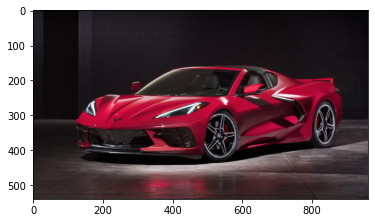

In [14]:
from matplotlib.pyplot import imshow
from PIL import Image
image_path = "960x0.jpg" #@param {type: "string"}
ood_img = Image.open(image_path) 

ood_tensor_img = trans(ood_img)

model.cpu().eval()
output = model(ood_tensor_img.unsqueeze(0))
print(torch.softmax(output,dim = 1))
print("Output: ", torch.argmax(output).item())
imshow(ood_img)

Get Convolutional Layers

In [5]:
model_children = list(model.children())
model_weights = []
conv_layers = []

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [18]:
# pass the image through all the layers
results = [conv_layers[0](ood_tensor_img.unsqueeze(0).cuda())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

# make a copy of the `results`
outputs = results

Layer Visualizations

In [23]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("output_imgs/layer_"+str(num_layer)+".png")
    # plt.show()
    plt.close()

torch.Size([64, 224, 224])
Saving layer 0 feature maps...
torch.Size([64, 224, 224])
Saving layer 1 feature maps...
torch.Size([64, 224, 224])
Saving layer 2 feature maps...
torch.Size([64, 224, 224])
Saving layer 3 feature maps...
torch.Size([64, 224, 224])
Saving layer 4 feature maps...
torch.Size([128, 112, 112])
Saving layer 5 feature maps...
torch.Size([128, 112, 112])
Saving layer 6 feature maps...
torch.Size([128, 112, 112])
Saving layer 7 feature maps...
torch.Size([128, 112, 112])
Saving layer 8 feature maps...
torch.Size([256, 56, 56])
Saving layer 9 feature maps...
torch.Size([256, 56, 56])
Saving layer 10 feature maps...
torch.Size([256, 56, 56])
Saving layer 11 feature maps...
torch.Size([256, 56, 56])
Saving layer 12 feature maps...
torch.Size([512, 28, 28])
Saving layer 13 feature maps...
torch.Size([512, 28, 28])
Saving layer 14 feature maps...
torch.Size([512, 28, 28])
Saving layer 15 feature maps...
torch.Size([512, 28, 28])
Saving layer 16 feature maps...


In [7]:
!pip install torchray

In [6]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchvision.utils import save_image
import cv2
# from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

img_to_tensor = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])

def perturbation(x,img,y, path, area=0.1):
  # Extremal perturbation
      masks_1,_ = extremal_perturbation(
          model.cuda(), x.cuda(), y,
          reward_func=contrastive_reward,
          perturbation="blur",
          debug=False,
          areas=[area],
          smooth=0.01,
          max_iter=800
      )
      ## Crop Important Area
      dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
      true_points = np.argwhere(dat)

      # take the smallest points and use them as the top left of your crop
      top_left = true_points.min(axis=0)
      # take the largest points and use them as the bottom right of your crop
      bottom_right = true_points.max(axis=0)

      img = img_to_tensor(img)

      save_image(img,path)
        
      img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

      start_point = (top_left[1], top_left[2]) 
      end_point = (bottom_right[1], bottom_right[2]) 


      color = (255, 0, 0) 
      thickness = 2
      img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # cv2.imwrite("img1.png",np.asarray(x))
      plt.imsave(path,img)
       

In [17]:
perturbation(ood_tensor_img.unsqueeze(0),ood_img,4,"output_imgs/original.png")

In [27]:
!pip install faiss-cpu

     |████████████████████████████████| 7.2MB 5.2MB/s 


In [7]:
import numpy as np
import faiss

In [8]:
images = []
for img, _ in tqdm(imgs):
      images.append(toPil(img.squeeze(0)))

In [ ]:
import torch.nn.functional as F

overall_layer = float("-inf")
model.cuda()
model.eval()
num_correct = 0
count = 0
features = []
targets = []
m = torch.nn.AvgPool2d((3, 2), stride=(1, 1))

for (tensor, y) in tqdm(dataloader_imgs):
    output = model(tensor.cuda())
    targets.append(y.item())


   # pass the image through all the layers
    results = [conv_layers[0](tensor.cuda())]
    for i in range(1, len(conv_layers)):
      # pass the result from the last layer to the next layer
      results.append(conv_layers[i](results[-1]))

    filters = []
    for num_layer in range(len(results)):
      layer_viz = results[num_layer]
      layer_viz = F.interpolate(layer_viz,(28,28))[0, :, :, :]
      layer_viz = layer_viz.data
      for filter in layer_viz.cpu().numpy():
        filters.append(filter)
        # print(filter.shape)
    filters = torch.tensor(filters)
    features.append(torch.flatten(m(filters)).cpu().detach().numpy())
      
    count+=1
    if(count == 200):
      break;

D = len(features[0])
N = len(features)


X = np.asarray(features)

   
index = faiss.IndexFlatL2(D)

index.add(X)
  
topk = 10

    ### In Distribution
    # test_output = model(trans(images[1]).unsqueeze(0).cuda())
    # search_query = np.asarray(X[1:2])
    # true_target = torch.argmax(test_output).item()

    # OOD Image
test_output = model(ood_tensor_img.unsqueeze(0).cuda())
     # pass the image through all the layers
results = [conv_layers[0](ood_tensor_img.unsqueeze(0).cuda())]
for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))

filters = []
for num_layer in range(len(results)):
      layer_viz = results[num_layer]
      layer_viz = F.interpolate(layer_viz,(28,28))[0, :, :, :]
      layer_viz = layer_viz.data
      for filter in layer_viz.cpu().numpy():
        filters.append(filter)
        # print(filter.shape)
filters = torch.tensor(filters)
    
test_features= torch.flatten(m(filters)).cpu().detach().numpy()
search_query = np.asarray([test_features])

true_target = torch.argmax(test_output).item()
    # print("Predicted Target ",true_target)

dists, ids = index.search(x=search_query, k=topk)


    # total_dist = sum(dists[0])
for i in ids[0]:
  if(targets[i] == true_target):
    num_correct +=1
      # print(targets[i])

print(num_correct)
    
print(dists)
print(ids)

debug_imgs = ids[0]



In [ ]:
from PIL import Image
num = 0
for i in debug_imgs:
  images[i].save("in-dist"+str(num)+".png")
  num+=1
  

In [ ]:
from PIL import Image
num = 0
for i in debug_imgs:
  perturbation(trans(images[i]).unsqueeze(0),images[i],targets[i],"output_imgs/ood"+str(num)+".png")
  # images[i].save("/home/anasa2/Incepto/Incepto/output_imgs/ood"+str(num)+".png")
  num+=1

## Single Image High Resolution

In [ ]:
!git clone https://github.com/krasserm/super-resolution.git

In [ ]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/utils.py /content/

In [ ]:
from model.srgan import generator
from utils import load_image, plot_sample
from model.common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('image2.png')[:,:,:3]
sr = resolve_single(model_hr, lr)
print("Testing Single Image Super Resolution")
plot_sample(lr, sr)
